# MPC demo

Author: Edward Schmerling

Used with author's permission

# Setup

Dependencies:
- System: python3
- Python: jupyter, ipywidgets, numpy, matplotlib, jax

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter ipywidgets numpy matplotlib jax
jupyter nbextension enable --py widgetsnbextension  # necessary for interactive sliders to show up
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/StanfordASL/AA203-Examples/blob/master/Lecture-15/Heuristic-based%20Nonlinear%20MPC%20for%20"Asteroids".ipynb) and run a cell containing these commands:
```
!pip install --upgrade matplotlib
```

In [19]:
import functools

import jax
import jax.numpy as jnp
import numpy as np; np.seterr(invalid="ignore")

import matplotlib.pyplot as plt; plt.rcParams.update({'font.size': 20})
import matplotlib.collections
import matplotlib.transforms
from ipywidgets import interact

# iLQR implementation

In [20]:
# `NamedTuple`s are used (more accurately, abused) in this code to minimize dependencies;
# much better JAX-compatible choices to fit the archetype of "parameterized function"
# would be `flax.struct.dataclass` or `equinox.Module`.
from typing import Callable, NamedTuple


class LinearDynamics(NamedTuple):
    f_x: jnp.array  # A
    f_u: jnp.array  # B

    def __call__(self, x, u, k=None):
        f_x, f_u = self
        return f_x @ x + f_u @ u if k is None else self[k](x, u)

    def __getitem__(self, key):
        return jax.tree_util.tree_map(lambda x: x[key], self)


class AffinePolicy(NamedTuple):
    l: jnp.array  # l
    l_x: jnp.array  # L

    def __call__(self, x, k=None):
        l, l_x = self
        return l + l_x @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_util.tree_map(lambda x: x[key], self)


class QuadraticCost(NamedTuple):
    c: jnp.array  # c
    c_x: jnp.array  # q
    c_u: jnp.array  # r
    c_xx: jnp.array  # Q
    c_uu: jnp.array  # R
    c_ux: jnp.array  # H.T

    @classmethod
    def from_pure_quadratic(cls, c_xx, c_uu, c_ux):
        return cls(
            jnp.zeros((c_xx.shape[:-2])),
            jnp.zeros(c_xx.shape[:-1]),
            jnp.zeros(c_uu.shape[:-1]),
            c_xx,
            c_uu,
            c_ux,
        )

    def __call__(self, x, u, k=None):
        c, c_x, c_u, c_xx, c_uu, c_ux = self
        return c + c_x @ x + c_u @ u + x @ c_xx @ x / 2 + u @ c_uu @ u / 2 + u @ c_ux @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_util.tree_map(lambda x: x[key], self)


class QuadraticStateCost(NamedTuple):
    v: jnp.array  # p (scalar)
    v_x: jnp.array  # p (vector)
    v_xx: jnp.array  # P

    @classmethod
    def from_pure_quadratic(cls, v_xx):
        return cls(
            jnp.zeros(v_xx.shape[:-2]),
            jnp.zeros(v_xx.shape[:-1]),
            v_xx,
        )

    def __call__(self, x, k=None):
        v, v_x, v_xx = self
        return v + v_x @ x + x @ v_xx @ x / 2 if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_util.tree_map(lambda x: x[key], self)


def rollout_state_feedback_policy(dynamics, policy, x0, step_range, x_nom=None, u_nom=None):

    def scan_fn(x, k):
        u = policy(x, k) if x_nom is None else u_nom[k] + policy(x - x_nom[k], k)
        x1 = dynamics(x, u, k)
        return (x1, (x1, u))

    xs, us = jax.lax.scan(scan_fn, x0, step_range)[1]
    return jnp.concatenate([x0[None], xs]), us


def riccati_step(
    current_step_dynamics: LinearDynamics,
    current_step_cost: QuadraticCost,
    next_state_value: QuadraticStateCost,
):
    f_x, f_u = current_step_dynamics
    c, c_x, c_u, c_xx, c_uu, c_ux = current_step_cost
    v, v_x, v_xx = next_state_value

    q = c + v
    q_x = c_x + f_x.T @ v_x
    q_u = c_u + f_u.T @ v_x
    q_xx = c_xx + f_x.T @ v_xx @ f_x
    q_uu = c_uu + f_u.T @ v_xx @ f_u
    q_ux = c_ux + f_u.T @ v_xx @ f_x

    l = -jnp.linalg.solve(q_uu, q_u)
    l_x = -jnp.linalg.solve(q_uu, q_ux)

    current_state_value = QuadraticStateCost(
        q - l.T @ q_uu @ l / 2,
        q_x - l_x.T @ q_uu @ l,
        q_xx - l_x.T @ q_uu @ l_x,
    )
    current_step_optimal_policy = AffinePolicy(l, l_x)
    return current_state_value, current_step_optimal_policy


def ensure_positive_definite(a, eps=1e-3):
    w, v = jnp.linalg.eigh(a)
    return (v * jnp.maximum(w, eps)) @ v.T


class TotalCost(NamedTuple):
    running_cost: Callable
    terminal_cost: Callable

    def __call__(self, xs, us):
        step_range = jnp.arange(us.shape[0])
        return jnp.sum(jax.vmap(self.running_cost)(xs[:-1], us, step_range)) + self.terminal_cost(xs[-1])


class EulerIntegrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using the Euler method."""
    ode: Callable
    dt: float

    @jax.jit
    def __call__(self, x, u, k):
        return x + self.dt * self.ode(x, u)


class RK4Integrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using a 4th order Runge-Kutta method."""
    ode: Callable
    dt: float

    @jax.jit
    def __call__(self, x, u, k):
        k1 = self.dt * self.ode(x, u)
        k2 = self.dt * self.ode(x + k1 / 2, u)
        k3 = self.dt * self.ode(x + k2 / 2, u)
        k4 = self.dt * self.ode(x + k3, u)
        return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


@jax.jit
def iterative_linear_quadratic_regulator(dynamics, total_cost, x0, u_guess, maxiter=100, atol=1e-3):
    running_cost, terminal_cost = total_cost
    n, (N, m) = x0.shape[-1], u_guess.shape
    step_range = jnp.arange(N)

    xs, us = rollout_state_feedback_policy(dynamics, lambda x, k: u_guess[k], x0, step_range)
    j = total_cost(xs, us)

    def continuation_criterion(loop_vars):
        i, _, _, j_curr, j_prev = loop_vars
        return (j_curr < j_prev - atol) & (i < maxiter)

    def ilqr_iteration(loop_vars):
        i, xs, us, j_curr, j_prev = loop_vars

        f_x, f_u = jax.vmap(jax.jacobian(dynamics, (0, 1)))(xs[:-1], us, step_range)
        c = jax.vmap(running_cost)(xs[:-1], us, step_range)
        c_x, c_u = jax.vmap(jax.grad(running_cost, (0, 1)))(xs[:-1], us, step_range)
        (c_xx, c_xu), (c_ux, c_uu) = jax.vmap(jax.hessian(running_cost, (0, 1)))(xs[:-1], us, step_range)
        v, v_x, v_xx = terminal_cost(xs[-1]), jax.grad(terminal_cost)(xs[-1]), jax.hessian(terminal_cost)(xs[-1])

        # Ensure quadratic cost terms are positive definite.
        c_zz = jnp.block([[c_xx, c_xu], [c_ux, c_uu]])
        c_zz = jax.vmap(ensure_positive_definite)(c_zz)
        c_xx, c_uu, c_ux = c_zz[:, :n, :n], c_zz[:, -m:, -m:], c_zz[:, -m:, :n]
        v_xx = ensure_positive_definite(v_xx)

        linearized_dynamics = LinearDynamics(f_x, f_u)
        quadratized_running_cost = QuadraticCost(c, c_x, c_u, c_xx, c_uu, c_ux)
        quadratized_terminal_cost = QuadraticStateCost(v, v_x, v_xx)

        def scan_fn(next_state_value, current_step_dynamics_cost):
            current_step_dynamics, current_step_cost = current_step_dynamics_cost
            current_state_value, current_step_policy = riccati_step(
                current_step_dynamics,
                current_step_cost,
                next_state_value,
            )
            return current_state_value, current_step_policy

        policy = jax.lax.scan(scan_fn,
                              quadratized_terminal_cost, (linearized_dynamics, quadratized_running_cost),
                              reverse=True)[1]

        def rollout_linesearch_policy(alpha):
            # Note that we roll out the true `dynamics`, not the `linearized_dynamics`!
            l, l_x = policy
            return rollout_state_feedback_policy(dynamics, AffinePolicy(alpha * l, l_x), x0, step_range, xs, us)

        # Backtracking line search (step sizes evaluated in parallel).
        all_xs, all_us = jax.vmap(rollout_linesearch_policy)(0.5**jnp.arange(16))
        js = jax.vmap(total_cost)(all_xs, all_us)
        a = jnp.argmin(js)
        j = js[a]
        xs = jnp.where(j < j_curr, all_xs[a], xs)
        us = jnp.where(j < j_curr, all_us[a], us)
        return i + 1, xs, us, jnp.minimum(j, j_curr), j_curr

    i, xs, us, j, _ = jax.lax.while_loop(continuation_criterion, ilqr_iteration, (0, xs, us, j, jnp.inf))

    return {
        "optimal_trajectory": (xs, us),
        "optimal_cost": j,
        "num_iterations": i,
    }

# "Asteroids" setup
It turns out that "Asteroids" isn't very fun if you can't shoot the asteroids out of your way as you're coasting.
Feel free to play with `ContinuousTimeSpaceshipDynamics` (you may have to drastically reduce the number of asteroids, see the last section below);
otherwise this notebook uses the extra maneuverability offered by `ContinuousTimeRocketCarDynamics` to illustrate more
interesting MPC behavior.

In [21]:
class ContinuousTimeSpaceshipDynamics(NamedTuple):

    def __call__(self, state, control):
        x, y, q, v_x, v_y = state
        r, a = control
        return jnp.array([
            v_x,
            v_y,
            r,
            a * jnp.cos(q),
            a * jnp.sin(q),
        ])


class ContinuousTimeRocketCarDynamics(NamedTuple):

    def __call__(self, state, control):
        x, y, q, v = state
        r, a = control
        return jnp.array([
            v * jnp.cos(q),
            v * jnp.sin(q),
            r,  # Note that these dynamics allow turning in place, unlike boring terrestrial cars.
            a,
        ])


class Asteroid(NamedTuple):
    center: jnp.array
    radius: jnp.array
    velocity: jnp.array = 0

    def at_time(self, time):
        return self._replace(center=self.center + self.velocity * time)


class Environment(NamedTuple):
    asteroids: Asteroid
    ship_radius: jnp.array
    sensing_radius: jnp.array
    bounds: jnp.array

    @classmethod
    def create(cls, num_asteroids, ship_radius=1.0, sensing_radius=5, bounds=(50, 40)):
        bounds = np.array(bounds)
        return cls(
            Asteroid(
                np.random.rand(num_asteroids, 2) * bounds,
                1 + 2 * np.random.rand(num_asteroids),
                np.random.randn(num_asteroids, 2),
            ), ship_radius, sensing_radius, bounds)

    def at_time(self, time):
        return self._replace(asteroids=self.asteroids.at_time(time))

    def wrap_vector(self, vector):
        return (vector + self.bounds / 2) % self.bounds - self.bounds / 2

    def sense(self, position):
        deltas = self.wrap_vector(position - self.asteroids.center)
        return self._replace(asteroids=self.asteroids._replace(radius=jnp.where(
            jnp.linalg.norm(deltas, axis=-1) -
            self.asteroids.radius < self.sensing_radius, self.asteroids.radius, np.nan)))

    def plot(self, state=None, plan=None, history=None, sensor=False, scaled_thrust=None, ax=None):
        pose = np.full(3, np.nan) if state is None else state[:3]
        plan = np.full((0, 2), np.nan) if plan is None else plan[:, :2]
        history = np.full((0, 2), np.nan) if history is None else history[:, :2]
        scaled_thrust = np.full((), np.nan) if scaled_thrust is None else scaled_thrust

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.set_xlim(0, self.bounds[0])
            ax.set_ylim(0, self.bounds[1])
            ax.set_aspect(1)
            asteroids = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Circle(np.zeros(2), r) for r in self.asteroids.radius] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    color="black",
                ))
            ship = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Polygon(self.ship_radius * np.array([[-.2, -.4], [1., 0], [-.2, .4]]))] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    color="orange",
                    zorder=10,
                ))
            circle = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Circle(np.zeros(2), self.sensing_radius)] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    facecolor=(0, 0, 0, 0),
                    edgecolor="black",
                    linestyle="--",
                    zorder=10,
                ))
            thruster = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Polygon(self.ship_radius * np.array([[-1., 0.], [0., -.25], [0., .25]]))] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    color="red",
                    zorder=5,
                ))
            plan_line = ax.plot(plan[:, 0], plan[:, 1], color="green")[0]
            history_line = ax.plot(history[:, 0], history[:, 1], color="blue")[0]
        else:
            fig = ax.figure
            asteroids, ship, circle, thruster = ax.collections
            plan_line, history_line = ax.lines
        screen_offsets = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        asteroids.set_offsets(
            (self.wrap_vector(self.asteroids.center) + self.bounds * screen_offsets[:, None, :]).reshape(-1, 2))
        if sensor:
            asteroids.set_alpha(np.where(np.isnan(self.sense(pose[:2]).asteroids.radius), 0.1, 1.0))
        ship.set_offsets(self.wrap_vector(pose[:2]) + self.bounds * screen_offsets)
        ship.set_transform(matplotlib.transforms.Affine2D().rotate(pose[2]) + ax.transData)
        circle.set_offsets(self.wrap_vector(pose[:2] if sensor else np.full(2, np.nan)) + self.bounds * screen_offsets)
        thruster.set_offsets(self.wrap_vector(pose[:2]) + self.bounds * screen_offsets)
        thruster.set_transform(matplotlib.transforms.Affine2D().scale(0.2 + 0.8 * scaled_thrust, 1).rotate(pose[2]) +
                               ax.transData)

        def tile_line(line):
            if line.shape[0] == 0:
                return line
            irange, jrange = [
                range(int(x[0]), int(x[1] + 1))
                for x in zip(np.min(line, 0) // self.bounds,
                             np.max(line, 0) // self.bounds)
            ]
            return np.concatenate([
                np.pad(line - np.array([i, j]) * self.bounds, ((0, 1), (0, 0)), constant_values=np.nan)
                for i in irange
                for j in jrange
            ], 0)

        plan_line.set_data(*tile_line(plan).T)
        history_line.set_data(*tile_line(history).T)
        return fig, ax

# Visualizaing asteroid environment

In [ ]:
# Problem parameters.
T = 125
dt = 0.1
dynamics = RK4Integrator(ContinuousTimeRocketCarDynamics(), dt)
start_state = np.array([5., 5., 0., 0.])
goal_position = np.array([45., 35.])

np.random.seed(2)
env = Environment.create(20)
fig, ax = env.plot()
plt.close()


@interact(k=(0, T))
def plot(k=0):
    env.at_time(k * dt).plot(ax=ax)
    return fig

interactive(children=(IntSlider(value=0, description='k', max=125), Output()), _dom_classes=('widget-interact'…

# Trajectory Optimization with Perfect Information (Full Horizon `T`)

In [23]:
class RunningCost(NamedTuple):
    env: Environment
    dt: jnp.array

    def __call__(self, state, control, step):
        # NOTE: many parameters (gains, offsets) in this function could be lifted to fields of `RunningCost`, in which
        # case you could experiment with changing these parameters without incurring `jax.jit` recompilation.
        asteroids = self.env.asteroids.at_time(step * self.dt)

        separation_distance = jnp.where(
            jnp.isnan(asteroids.radius), np.inf,
            jnp.linalg.norm(self.env.wrap_vector(state[:2] - asteroids.center), axis=-1) - asteroids.radius -
            self.env.ship_radius)
        collision_avoidance_penalty = jnp.sum(
            jnp.where(separation_distance > 0.3, 0, 1e4 * (0.3 - separation_distance)**2))

        r, a = control
        yaw_rate_penalty = 1e4 * jnp.maximum(jnp.abs(r) - np.pi / 2, 0)**2
        acceleration_penalty = 1e4 * jnp.maximum(jnp.abs(a) - 4, 0)**2  # explicitly allowing for deceleration.

        return collision_avoidance_penalty + yaw_rate_penalty + acceleration_penalty + r**2 + a**2


class FullHorizonTerminalCost(NamedTuple):
    env: Environment
    goal_position: jnp.array

    @classmethod
    def create_ignoring_extra_args(cls, env, goal_position, *args, **kwargs):
        return cls(env, goal_position)

    def __call__(self, state):
        return 1000 * (jnp.sum(jnp.square(state[:2] - self.goal_position)) + state[3]**2)

In [ ]:
# Here we incrementally add constraints to help trajectory optimization converge to a decent solution; i.e., we solve
# first in a completely empty environment (no asteroids) and use this trajectory to warm start the optimization in the
# populated environment.
# As we'll see in later cells, this isn't the most robust way to initialize iLQR; you can still get stuck in local
# minima (e.g., where you just plow through the thinnest point of a cluster of asteroids). Enterprising students may
# consider experimenting with multiple random initializations (if you use `jax.vmap`, this is more-or-less trivial to
# code!) or otherwise more complicated search methods (e.g., graph-based) for initializating the control sequence.
empty_env = Environment.create(0)
solution = iterative_linear_quadratic_regulator(
    dynamics,
    TotalCost(RunningCost(empty_env, dt), FullHorizonTerminalCost(empty_env, goal_position)),
    start_state,
    np.zeros((T, 2)),
)
solution = iterative_linear_quadratic_regulator(
    dynamics,
    TotalCost(RunningCost(env, dt), FullHorizonTerminalCost(env, goal_position)),
    start_state,
    solution["optimal_trajectory"][1],
)
solution = jax.tree_util.tree_map(np.array, solution)
states, controls = solution["optimal_trajectory"]
fig, ax = env.plot()
plt.close()


@interact(k=(0, T))
def plot(k=0):
    env.at_time(k * dt).plot(states[k], states[:k + 1], states[k:], ax=ax)
    return fig

interactive(children=(IntSlider(value=0, description='k', max=125), Output()), _dom_classes=('widget-interact'…

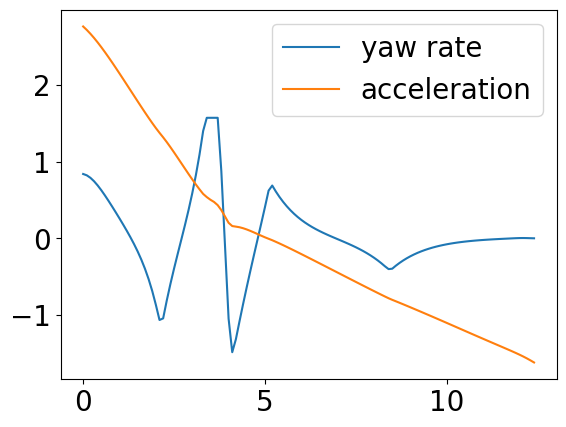

In [25]:
plt.plot(np.arange(T) * dynamics.dt, controls, label=["yaw rate", "acceleration"])
plt.legend()

# MPC with Perfect Information (Horizon `N`)
In case optimizing over the full horizon is too expensive (or perhaps there is no notion of "full horizon"), we consider now receding horizon control. Other reasons to consider an MPC formulation could include, e.g.,
- disturbance rejection (though there is no noise added in the simulations below),
- environmental uncertainty (see the next section on "MPC with Partial Observability").

In [26]:
@functools.partial(jax.jit, static_argnames=["running_cost_type", "terminal_cost_type", "limited_sensing", "N"])
def policy(state, env, dynamics, running_cost_type, terminal_cost_type, limited_sensing=False, N=20):
    if limited_sensing:
        env = env.sense(state[:2])
    empty_env = Environment.create(0)
    solution = iterative_linear_quadratic_regulator(
        dynamics,
        TotalCost(
            running_cost_type(empty_env, dynamics.dt),
            terminal_cost_type.create_ignoring_extra_args(
                empty_env,
                goal_position,
                state[:2],
                empty_env.sensing_radius,
            ),
        ),
        state,
        np.zeros((N, 2)),
    )
    solution = iterative_linear_quadratic_regulator(
        dynamics,
        TotalCost(
            running_cost_type(env, dynamics.dt),
            terminal_cost_type.create_ignoring_extra_args(
                env,
                goal_position,
                state[:2],
                env.sensing_radius,
            ),
        ),
        state,
        solution["optimal_trajectory"][1],
    )
    states, controls = solution["optimal_trajectory"]
    return controls[0], (states, controls)


def simulate_mpc(start_state, env, dynamics, running_cost_type, terminal_cost_type, limited_sensing=False, N=20, T=T):
    states = [start_state]
    controls = []
    plans = []
    for t in range(T):
        control, (mpc_states, mpc_controls) = policy(states[-1], env.at_time(t * dynamics.dt), dynamics,
                                                     running_cost_type, terminal_cost_type, limited_sensing, N)
        states.append(mpc_states[1])
        controls.append(control)
        plans.append(mpc_states)
    states = np.array(states)
    controls = np.array(controls)
    plans = np.array(plans)

    plt.plot(np.arange(T) * dynamics.dt, controls, label=["yaw rate", "acceleration"])
    plt.legend()
    fig, ax = env.plot()
    plt.close()

    @interact(k=(0, T))
    def plot(k=0):
        env.at_time(k * dt).plot(
            states[k],
            states[:k + 1],
            plans[k] if k < T else None,
            sensor=limited_sensing,
            ax=ax,
        )
        return fig

    return plot

## Using the `FullHorizonTerminalCost` (overagressive)

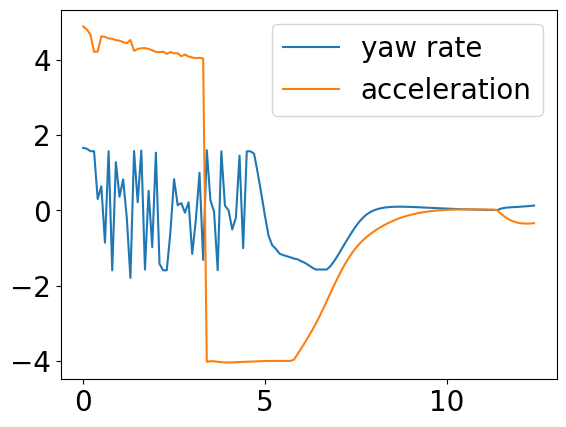

interactive(children=(IntSlider(value=0, description='k', max=125), Output()), _dom_classes=('widget-interact'…

<function __main__.simulate_mpc.<locals>.plot(k=0)>

In [27]:
simulate_mpc(start_state, env, dynamics, RunningCost, FullHorizonTerminalCost)

## Using a heuristic `MPCTerminalCost` (better, but requires tuning)
This is a completely made-up, hand-constructed terminal cost function for illustrative purposes.
More principled approaches might include:
- working out some math to compute the cost-to-go (value function) for a simple tail policy (e.g., turn towards the goal and drive straight there),
- learning a terminal cost function from experience,
- more generally, using a direct method that can properly incorporate constraints, e.g., an augmented Lagrangian formulation/outer loop around iLQR, to disambiguate constraints (all currently soft) from costs.

In [28]:
class MPCTerminalCost(NamedTuple):
    env: Environment
    goal_position: jnp.array

    @classmethod
    def create_ignoring_extra_args(cls, env, goal_position, *args, **kwargs):
        return cls(env, goal_position)

    def __call__(self, state):
        # We use a "Huber loss"-like penalty to encourage goal-seeking behavior; an L1 norm penalty on the terminal
        # state makes it so that early MPC iterations that are further from the goal don't feel a stronger "pull" than
        # later iterations.
        distance_to_goal = jnp.linalg.norm(state[:2] - self.goal_position)
        goal_penalty = jnp.where(distance_to_goal > 1, 2 * distance_to_goal - 1, distance_to_goal**2)
        speed_penalty = state[3]**2
        return 50 * (goal_penalty + speed_penalty)

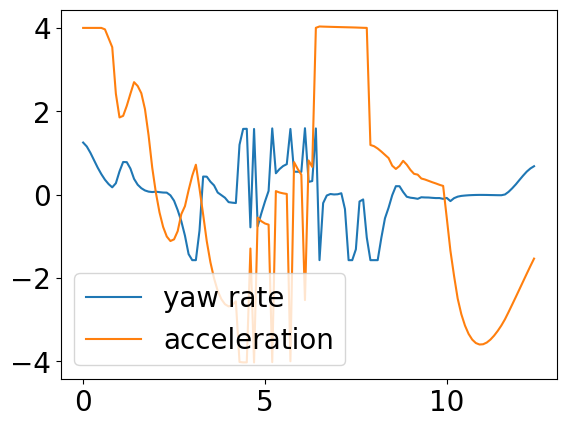

interactive(children=(IntSlider(value=0, description='k', max=125), Output()), _dom_classes=('widget-interact'…

<function __main__.simulate_mpc.<locals>.plot(k=0)>

In [ ]:
simulate_mpc(start_state, env, dynamics, RunningCost, MPCTerminalCost)

# MPC with Partial Observability (Horizon `N`)
Now we consider a limited sensing radius on our ship -- this is a stronger reason to apply MPC than, e.g., simply disturbance rejection (though I should note that MPC for tracking with constraints, which is a much more straightforward application of our discussions on linear MPC, is a topic for another notebook, another day...).

## Using the same `MPCTerminalCost` with limited sensing (now too bold!)

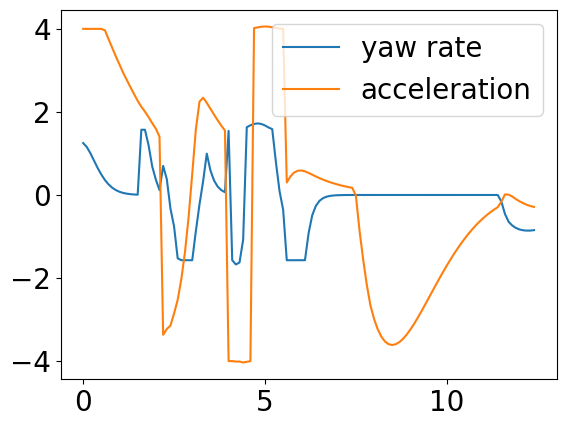

interactive(children=(IntSlider(value=0, description='k', max=125), Output()), _dom_classes=('widget-interact'…

<function __main__.simulate_mpc.<locals>.plot(k=0)>

In [30]:
simulate_mpc(start_state, env, dynamics, RunningCost, MPCTerminalCost, limited_sensing=True)

## More heuristic tuning to the rescue with `MPCTerminalCostAndSoftConstraint`
A more principled approach here could be to use reachability theory to reason about safe states from which you know you can avoid collision with any unforeseen asteroid (at least in a one-by-one fashion).

In [31]:
class MPCTerminalCostAndSoftConstraint(NamedTuple):
    env: Environment
    goal_position: jnp.array
    start_position: jnp.array
    trust_region_radius: jnp.array

    @classmethod
    def create_ignoring_extra_args(cls, *args, **kwargs):
        return cls(*args, **kwargs)

    def __call__(self, state):
        # We use a "Huber loss"-like penalty to encourage goal-seeking behavior; an L1 norm penalty on the terminal
        # state makes it so that early MPC iterations that are further from the goal don't feel a stronger "pull" than
        # later iterations.
        distance_to_goal = jnp.linalg.norm(state[:2] - self.goal_position)
        goal_penalty = jnp.where(distance_to_goal > 1, 2 * distance_to_goal - 1, distance_to_goal**2)
        speed_penalty = state[3]**2

        # With limited sensing, we also now enforce a trust region to stay near where we start instead of having MPC
        # plans charge off into the great unknown.
        distance_from_start = jnp.sqrt(jnp.sum(jnp.square(state[:2] - self.start_position)) + 1e-3)
        trust_region_penalty = jnp.where(distance_from_start < self.trust_region_radius, 0,
                                         (distance_from_start - self.trust_region_radius)**2)

        return 50 * (goal_penalty + speed_penalty) + 1000 * trust_region_penalty

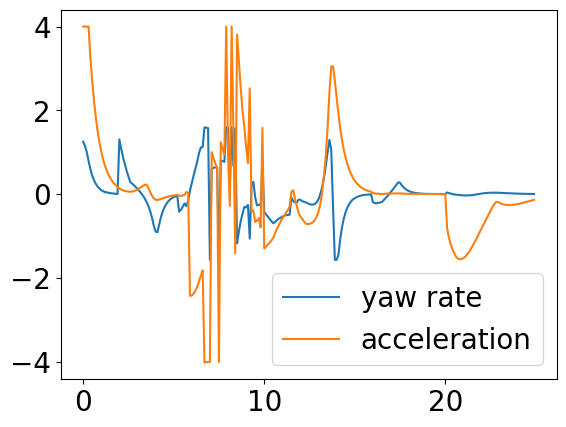

interactive(children=(IntSlider(value=0, description='k', max=250), Output()), _dom_classes=('widget-interact'…

<function __main__.simulate_mpc.<locals>.plot(k=0)>

In [32]:
simulate_mpc(start_state, env, dynamics, RunningCost, MPCTerminalCostAndSoftConstraint, limited_sensing=True, T=250)

# Playing with `ContinuousTimeSpaceshipDynamics`

In [33]:
# Problem parameters.
T = 100
dt = 0.1
start_state = np.array([5., 5., 0., 0., 0.])
goal_position = np.array([45., 35.])

np.random.seed(7)
env = Environment.create(10, ship_radius=2.0)
fig, ax = env.plot()
plt.close()


@interact(k=(0, T))
def plot(k=0):
    env.at_time(k * dt).plot(ax=ax)
    return fig

interactive(children=(IntSlider(value=0, description='k'), Output()), _dom_classes=('widget-interact',))

In [34]:
class RunningCost(NamedTuple):
    env: Environment
    dt: jnp.array

    def __call__(self, state, control, step):
        asteroids = self.env.asteroids.at_time(step * self.dt)

        position = state[:2]
        separation_distance = jnp.where(
            jnp.isnan(asteroids.radius), np.inf,
            jnp.linalg.norm(self.env.wrap_vector(position - asteroids.center), axis=-1) - asteroids.radius -
            self.env.ship_radius)
        collision_avoidance_penalty = jnp.sum(
            jnp.where(separation_distance > 0.2, 0, 1e4 * (0.2 - separation_distance)**2))

        r, a = control
        yaw_rate_limit = 1e4 * jnp.maximum(jnp.abs(r) - np.pi, 0)**2
        acceleration_limit = 1e4 * jnp.maximum(jnp.abs(a - 2) - 2, 0)**2  # all gas; no brakes.

        return collision_avoidance_penalty + yaw_rate_limit + acceleration_limit + r**2 + a**2


class FullHorizonTerminalCost(NamedTuple):
    env: Environment
    goal_position: jnp.array

    def __call__(self, state):
        return 1000 * (jnp.sum(jnp.square(state[:2] - self.goal_position)) + state[3]**2 + state[4]**2)

In [ ]:
empty_env = Environment.create(0)
solution = iterative_linear_quadratic_regulator(
    RK4Integrator(ContinuousTimeSpaceshipDynamics(), dt),
    TotalCost(RunningCost(empty_env, dt), FullHorizonTerminalCost(empty_env, goal_position)),
    start_state,
    np.zeros((T, 2)),
)
solution = iterative_linear_quadratic_regulator(
    RK4Integrator(ContinuousTimeSpaceshipDynamics(), dt),
    TotalCost(RunningCost(env, dt), FullHorizonTerminalCost(env, goal_position)),
    start_state,
    solution["optimal_trajectory"][1],
)
solution = jax.tree_util.tree_map(np.array, solution)
states, controls = solution["optimal_trajectory"]
fig, ax = env.plot()
plt.close()


@interact(k=(0, T))
def plot(k=0):
    env.at_time(k * dt).plot(
        states[k],
        states[:k + 1],
        states[k:],
        sensor=False,
        scaled_thrust=controls[k][1] / 4 if k < T else None,
        ax=ax,
    )
    return fig

interactive(children=(IntSlider(value=0, description='k'), Output()), _dom_classes=('widget-interact',))

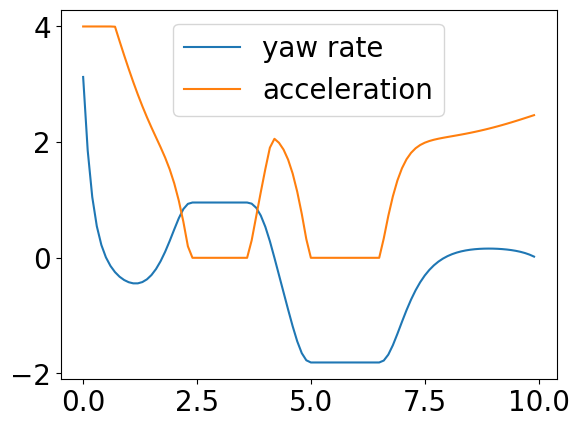

In [18]:
plt.plot(np.arange(T) * dynamics.dt, controls, label=["yaw rate", "acceleration"])
plt.legend()